# Projektrealisierung



## 0. Introduction

**Aufgabe:**
Erstellung einer Applikation mit Kamera Input, die Zeichensprache von nicht-Hörenden / nicht-Sprechenden Personen konvertiert und diese anderen Meeting-Teilnehmern als Untertitel ausgibt. Bereitstellung eines Frontends zu Demonstrationszwecken und einer API, um die Modelle in andere Applikationen wie Teams oder Discord zu integrieren.

This notebook is part of DeepSL, a project on the topic sign language translation for the module Projektrealisierung in course WWI20DSB at the Baden-Wuerttemberg Cooperative State University Mannheim.

This notebook focuses on the detection part, its evaluation and the evaluation of the model combination.

How to execute this notebook:
1. Go to https://drive.google.com/file/d/1be8Cai-xqnSQKJQmnVxAuEFmm_xU1N9Z/view?usp=sharing (containing the zip file with the 100 glosses), then add a shortcut to this file in your drive so that it is integrated into your google drive
2. Go to https://drive.google.com/file/d/1EIE3FUYi_hvIxAEqxaxxmrHlE1GDmcND/view?usp=sharing (containing the WASL100.json file), then add a shortcut to this file in your drive
3. Go to https://drive.google.com/drive/folders/1FLGfE8WsyULEGEW1O1kwFm6pIKUWJ-Kl?usp=sharing (containing the videos used for testing the detection and model combination), then add a shortcut to this file in your drive
4. Go to https://drive.google.com/file/d/16vo3Tu_rFbu134VjXTq7_KqVkefL2jAq/view?usp=sharing (containing the test image for showing the bounding boxes), then add a shortcut to this file in your drive
5. Go to https://drive.google.com/drive/folders/1cjPciYMTOEaD2USHd_B94xNLUHVlSKsg?usp=sharing (containing the weights of the model), then add a shortcut to this file in your drive
6. Simply run the cells in this notebook


## 1. Setup / Prequesites

### 1.1 Downloads

In [1]:
# packages to predict and perform the cuts of the input videos in regard to time and surface
! pip install moviepy
! pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 36.4 MB/s eta 0:00:00


In [2]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
# o that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# connecting to Kaggle to be able to download the data set
! pip install kaggle
! mkdir -p ~/.kaggle/
# for the case, that kaggle.json is stored in the drive
! cp drive/MyDrive/kaggle.json ~/.kaggle/
# for the case, if kaggle.json is stored under the root dir
# ! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### 1.2 Imports

In [4]:
# import  libraries needed for the detection part
import mediapipe as mp
import pandas as pd
from moviepy.editor import VideoFileClip
from moviepy.video.fx.all import crop
from keras.metrics import IoU
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import tensorflow as tf
import pathlib
import random

# import libraries needed for the recognition part
from typing import Tuple
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, \
ZeroPadding3D, ZeroPadding2D, RandomRotation, RandomCrop,RandomFlip, RandomZoom, BatchNormalization
from tensorflow.keras.layers import Layer
import shutil

### 1.3 Configuration

In [5]:
# setting the face_mesh of MediaPipe to enable the Face Detection
mp_face_mesh = mp.solutions.face_mesh

In [6]:
# Setting the directories where the data files are stored
# Data Dirs
DATA_DIR_EVAL = "/content/ms_asl/"

# Train Files
MSASL_train_eval = DATA_DIR_EVAL + 'MSASL_train.json'

# Val Files
MSASL_val_eval = DATA_DIR_EVAL + 'MSASL_val.json'

# Test Files
MSASL_test_eval = DATA_DIR_EVAL + 'MSASL_test.json'

data_files_eval = [MSASL_train_eval, MSASL_val_eval, MSASL_test_eval]

In [7]:
# download the ASL dataset and unzipping it into the data diretory
! kaggle datasets download -d saurabhshahane/american-sign-language-dataset
! unzip -n -q american-sign-language-dataset.zip -d ms_asl

100% 1.91M/1.91M [00:01<00:00, 2.04MB/s]
100% 1.91M/1.91M [00:01<00:00, 1.79MB/s]


## 2. Detection

### 2.1 Detection Model

In [8]:
# Function to use MediaPipe to detect faces in an image
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

# Function to draw the predicted landmarks of face and hands for calculating the bounding boxes
def draw_landmarks(image, results):
    mp_holistic = mp.solutions.holistic  # Holistic model
    mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

    # Draw left hand connections
    image_new = mp_drawing.draw_landmarks(
        image,
        landmark_list=results.left_hand_landmarks,
        connections=mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=(232, 254, 255), thickness=1, circle_radius=4
        ),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=(255, 249, 161), thickness=2, circle_radius=2
        ),
    )

    image = image_new if image_new is not None else image

    # Draw right hand connections
    image_new = mp_drawing.draw_landmarks(
        image,
        landmark_list=results.right_hand_landmarks,
        connections=mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=(232, 254, 255), thickness=1, circle_radius=4
        ),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=(255, 249, 161), thickness=2, circle_radius=2
        ),
    )
    image = image_new if image_new is not None else image

    return image

# Function for cutting the videos according the the predicted start/end frames of the signs
def cut_videos(start_frame, end_frame, video_path, counter, min_x, max_x, min_y, max_y ):
    cap_temp = cv2.VideoCapture(video_path)


    output_path = video_path.split(".")[0] + str(counter) + "." + video_path.split(".")[1]

    # Get the frames per second (fps) and frame count of the video
    fps = cap_temp.get(cv2.CAP_PROP_FPS)
    frame_count = cap_temp.get(cv2.CAP_PROP_FRAME_COUNT)

    # Set the start and end frame numbers
    start_frame_num = start_frame
    end_frame_num = end_frame

    # Check if the specified frames are within the video's range
    if start_frame_num > frame_count or end_frame_num > frame_count:
        print("Invalid frame range.")
        cap_temp.release()
        exit()

    # Set the start frame position
    cap_temp.set(cv2.CAP_PROP_POS_FRAMES, start_frame_num)

    # Create a VideoWriter object to write the extracted frames
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    output = cv2.VideoWriter(output_path, fourcc, fps, (int(cap_temp.get(3)), int(cap_temp.get(4))))

    # Read and write the frames within the specified range
    current_frame = start_frame_num

    while current_frame <= end_frame_num:
        ret, frame = cap_temp.read()
        if not ret:
            break

        height, width = frame.shape[:2]
        # print(height, width)
        # cropped_frame = frame[int(min_x*width):int(max_x*width), int(min_y*height):int(max_y*height)]

        # print(cropped_frame.shape)

        output.write(frame)
        current_frame += 1

    cap_temp.release()

    return {output_path: [int(min_x*width), int(min_y*height), int(max_x*width), int(max_y*height)]}

# Function to filter the min/max x/y coordinates of the hands needed for calculating the bounding box
def filter_min_max(lst):
    x_vals = [i.x for i in lst]
    y_vals = [i.y for i in lst]
    min_x = min(x_vals)
    max_x = max(x_vals)
    min_y = min(y_vals)
    max_y = max(y_vals)
    return [min_x, max_x, min_y, max_y]

# Fucntion to filter the min/max x/y coordinates of the face needed for calculating the bounding box
def get_min_max_of_face(frame):
    with mp_face_mesh.FaceMesh(static_image_mode=True,
                           max_num_faces=1,
                        #    refine_landmarks=True,
                           min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(frame)

    if bool(results.multi_face_landmarks):
        face_landmarks = results.multi_face_landmarks[0]
        face_coordinates = [face_landmark for face_landmark in face_landmarks.landmark]
        return filter_min_max(face_coordinates)
    else:
        return [None, None, None, None]

# Function to create a dataframe to store the extracted coordinates needed for calculating the bounding box
def create_empty_dataframe():
    return pd.DataFrame(columns=["left_hand_x_min", "left_hand_x_max", "left_hand_y_min", "left_hand_y_max",
                                                    "right_hand_x_min", "right_hand_x_max", "right_hand_y_min", "right_hand_y_max",
                                                    "face_x_min", "face_x_max", "face_y_min", "face_y_max"])

# Function to cut the calculated bounding box out of the video
def crop_videos_from_dataframe(df: pd.DataFrame, cap):

    df = df.fillna(0.5)

    min_x = np.nanmin(np.array((df["left_hand_x_min"].dropna().min(),df["face_x_min"].dropna().min(), df["right_hand_x_min"].dropna().min())))
    min_y = np.nanmin(np.array((df["left_hand_y_min"].dropna().min(),df["face_y_min"].dropna().min(), df["right_hand_y_min"].dropna().min())))
    max_x = np.nanmax(np.array((df["left_hand_x_max"].dropna().max(),df["face_x_max"].dropna().max(), df["right_hand_x_max"].dropna().max())))
    max_y = np.nanmax(np.array((df["left_hand_y_max"].dropna().max(),df["face_y_max"].dropna().max(), df["right_hand_y_max"].dropna().max())))

    face_middle = (df["face_x_min"].dropna().mean() + df["face_x_max"].dropna().mean())/2
    distance = max(face_middle-min_x, max_x-face_middle)

    min_x = face_middle-distance-0.1 if face_middle-distance-0.1 > 0 else 0
    max_x = face_middle+distance+0.1  if face_middle+distance+0.1 < 1 else 1
    min_y = min_y-0.1 if min_y-0.1 > 0 else 0
    max_y = max_y+0.1 if max_y+0.1 < 1 else 1
    print(face_middle-distance, face_middle+distance, min_y, max_y)
    return face_middle-distance, face_middle+distance, min_y, max_y

In [9]:
# Function to call all the above functions to perform the sign detection and the cutting with one click
def get_time_and_bounding_boxes(video_path):
  cap = cv2.VideoCapture(video_path)

  fps = cap.get(cv2.CAP_PROP_FPS)

  threshold_counter_no_hand = fps // 2
  threshold_min_video_len = fps // 2

  video_times = []
  crop_video = []
  video_postions = create_empty_dataframe()
  start_time_temp = None
  counter_no_hand = None
  frame_counter = 0

  coordinates = []

  # Check if camera opened successfully
  if (cap.isOpened()== False):
    print("Error opening video stream or file")

  with mp.solutions.holistic.Holistic(
          min_detection_confidence=0.5, min_tracking_confidence=0.5
      ) as holistic:
    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        frame_counter += 1

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        if results is not None:
          if results.left_hand_landmarks is not None:
            video_postions_temp = filter_min_max([hand_landmarks for hand_landmarks in results.left_hand_landmarks.landmark])
          else:
            video_postions_temp = [None, None, None, None]
          if results.right_hand_landmarks is not None:
            video_postions_temp.extend(filter_min_max([hand_landmarks for hand_landmarks in results.right_hand_landmarks.landmark]))
          else:
            video_postions_temp.extend([None, None, None, None])

          video_postions_temp.extend(get_min_max_of_face(frame))
          video_postions_temp_df = pd.DataFrame([video_postions_temp],
                                            columns=["left_hand_x_min", "left_hand_x_max", "left_hand_y_min", "left_hand_y_max",
                                                      "right_hand_x_min", "right_hand_x_max", "right_hand_y_min", "right_hand_y_max",
                                                      "face_x_min", "face_x_max", "face_y_min", "face_y_max"])
          video_postions = pd.concat([video_postions, video_postions_temp_df], ignore_index=True)

        if results.right_hand_landmarks is None and results.left_hand_landmarks is None:

          if counter_no_hand is not None:
            counter_no_hand += 1
            if counter_no_hand > threshold_counter_no_hand:
              if (frame_counter - start_time_temp) > threshold_min_video_len:   # fps:
                end_time_temp = frame_counter - counter_no_hand
                if (end_time_temp - start_time_temp) < threshold_min_video_len:
                  end_time_temp = start_time_temp + threshold_min_video_len
                  if frame_counter < end_time_temp:
                    end_time_temp = frame_counter

                video_times.append((start_time_temp, end_time_temp))
                min_x, max_x, min_y, max_y = crop_videos_from_dataframe(video_postions, cap)
                coordinates.append((min_x, min_y, max_x, max_y))
                video_postions = create_empty_dataframe()
                crop_video.append(cut_videos(start_time_temp, end_time_temp, video_path, len(video_times), min_x, max_x, min_y, max_y))
                start_time_temp = None
                counter_no_hand = None

        else:
          if start_time_temp is None:
            start_time_temp = frame_counter
            counter_no_hand = 0

        if results is not None and image is not None:
          image = draw_landmarks(image, results)

      # Break the loop
      else:
        break

  if start_time_temp is not None:
    if (frame_counter - start_time_temp) > fps:
      # video_times.append((start_time_temp, frame_counter))
      end_time_temp = frame_counter - counter_no_hand
      if (end_time_temp - start_time_temp) < threshold_min_video_len:
        end_time_temp = start_time_temp + threshold_min_video_len
        if frame_counter < end_time_temp:
          end_time_temp = frame_counter
      video_times.append((start_time_temp, end_time_temp))
      min_x, max_x, min_y, max_y = crop_videos_from_dataframe(video_postions, cap)
      coordinates.append((min_x, min_y, max_x, max_y))
      video_postions = create_empty_dataframe()
      crop_video.append(cut_videos(start_time_temp, frame_counter, video_path, len(video_times), min_x, max_x, min_y, max_y))

  # When everything done, release the video capture object
  cap.release()

  for item in crop_video:
      for key, value in item.items():
          clip = VideoFileClip(key)
          new_clip = crop(clip, x1=value[0], y1=value[1], x2=value[2], y2=value[3])
          target_path_cropped = key.split(".")[0] + "cropped." + key.split(".")[1]
          print(new_clip.write_videofile(target_path_cropped, audio=False))   # , codec='mpeg4'

  return coordinates, video_times

### 2.2 Use Detection Model

In [10]:
# setting the video paths for the 5 videos used to evaluate the detection and model combination
video_for_eval_1 = "/content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA.mp4"
video_for_eval_2 = "/content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M.mp4"
video_for_eval_3 = "/content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc.mp4"
video_for_eval_4 = "/content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c.mp4"
video_for_eval_5 = "/content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q.mp4"

Predicting the Bounding Boxes and the Start/End times of the signs for each of the five videos

In [11]:
predicted_coordinates_1, predicted_times_1 = get_time_and_bounding_boxes(video_for_eval_1)

-0.016097933053970337 0.9925321453172742 0.24278976917266845 1
0.20563732900402765 0.7870223522186279 0.2594806790351868 1
0.23505008220672607 0.7649499177932739 0.049794682860374445 1
-0.07642138004302979 1.0764213800430298 0.19524415731430053 1
-0.10435435175895691 1.104354351758957 0.3422842860221863 1
0.16787049174308777 0.8321295082569122 0.14771872162818908 1
0.1342868208885193 0.8657131791114807 0.29766067266464236 1
0.17222678661346436 0.8277732133865356 0.211819851398468 1
0.21119704842567444 0.7888029515743256 0.3588266909122467 1
0.11778420209884644 0.8822157979011536 0.10925469696521758 1
0.19724025649995336 0.7976926565170288 0.26469036340713503 1
-0.22308111190795898 1.223081111907959 0.30115499496459963 1
-0.24869859112160553 1.2454297542572021 0.017235496640205378 1
0.11452031135559082 0.8854796886444092 0.3822628200054169 1
-0.0151548310146703 1.007853627204895 0.16641857624053955 1
-0.0407719612121582 1.0407719612121582 0.1518584132194519 1
0.041513800621032715 0.9584

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA1cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA2cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA2cropped.mp4



t:  76%|███████▌  | 25/33 [00:00<00:00, 41.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA2.mp4, 876960 bytes wanted but 0 bytes read,at frame 32/33, at time 1.07/1.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA2cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA3cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA3cropped.mp4



t:  72%|███████▏  | 26/36 [00:01<00:00, 36.02it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA3.mp4, 876960 bytes wanted but 0 bytes read,at frame 35/36, at time 1.17/1.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA3cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA4cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA4cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA4cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA5cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA5cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA5cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA6cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA6cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA6cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA7cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA7cropped.mp4



t:  97%|█████████▋| 70/72 [00:01<00:00, 61.86it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA7.mp4, 876960 bytes wanted but 0 bytes read,at frame 71/72, at time 2.37/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA7cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA8cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA8cropped.mp4



t:  91%|█████████ | 41/45 [00:01<00:00, 59.40it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA8.mp4, 876960 bytes wanted but 0 bytes read,at frame 44/45, at time 1.47/1.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA8cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA9cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA9cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA9cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA10cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA10cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA10cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA11cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA11cropped.mp4



t:  91%|█████████ | 41/45 [00:01<00:00, 53.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA11.mp4, 876960 bytes wanted but 0 bytes read,at frame 44/45, at time 1.47/1.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA11cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA12cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA12cropped.mp4



t:  91%|█████████ | 41/45 [00:00<00:00, 57.06it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA12.mp4, 876960 bytes wanted but 0 bytes read,at frame 44/45, at time 1.47/1.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA12cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA13cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA13cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA13cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA14cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA14cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA14cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA15cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA15cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA15cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA16cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA16cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA16cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA17cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA17cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA17cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA18cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA18cropped.mp4



t:  98%|█████████▊| 41/42 [00:00<00:00, 57.97it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA18.mp4, 876960 bytes wanted but 0 bytes read,at frame 41/42, at time 1.37/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA18cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA19cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA19cropped.mp4



t:  86%|████████▌ | 36/42 [00:00<00:00, 51.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA19.mp4, 876960 bytes wanted but 0 bytes read,at frame 41/42, at time 1.37/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA19cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA20cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA20cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA20cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA21cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA21cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA21cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA22cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA22cropped.mp4



t:  82%|████████▏ | 37/45 [00:01<00:00, 51.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA22.mp4, 876960 bytes wanted but 0 bytes read,at frame 44/45, at time 1.47/1.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/uE3IDWh0xnA22cropped.mp4
None


In [12]:
predicted_coordinates_2, predicted_times_2 = get_time_and_bounding_boxes(video_for_eval_2)

0.04142042827772929 0.9547789692878723 0.027387136220932 1
-0.055117551237344686 1.0211330163180827 0.07518657445907592 1
0.36393405521502276 0.6468388438224792 0.07692579329013824 1
0.26457902411871315 0.7360380291938782 0.074020916223526 0.9635080456733703
0.28606977120593724 0.7145397067070007 0.0724134087562561 1
0.1634794195761553 0.8370117545127869 0.02126306444406509 1
0.24054416201331397 0.769079327583313 0.07165151238441467 1
0.16147286135975913 0.8399679064750671 0.07332679033279418 1
0.18252788465234282 0.8180797100067139 0.06878244280815124 1
0.20065839754210568 0.8020855188369751 0.07559383809566497 0.8895283102989197
0.23397210455802542 0.7729870080947876 0.06663123667240142 1
0.1775481517708628 0.8292971253395081 0.06189783811569213 1
-0.0034922361373901367 1.0045280412716024 0.062437707185745234 1
0.30822622593568294 0.7358564734458923 0.04667730033397674 1
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M1cropped.mp4.
Moviepy - Writi

t: 100%|██████████| 96/96 [00:02<00:00, 49.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M1.mp4, 518400 bytes wanted but 0 bytes read,at frame 95/96, at time 3.96/3.96 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M1cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M2cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M2cropped.mp4



t:  82%|████████▏ | 93/113 [00:01<00:00, 125.75it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M2.mp4, 518400 bytes wanted but 0 bytes read,at frame 112/113, at time 4.67/4.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M2cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M3cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M3cropped.mp4



t:   9%|▊         | 3/35 [00:00<00:09,  3.44it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M3.mp4, 518400 bytes wanted but 0 bytes read,at frame 34/35, at time 1.42/1.42 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M3cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M4cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M4cropped.mp4



t:  93%|█████████▎| 39/42 [00:00<00:00, 55.77it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M4.mp4, 518400 bytes wanted but 0 bytes read,at frame 41/42, at time 1.71/1.71 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M4cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M5cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M5cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M5cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M6cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M6cropped.mp4



t:  71%|███████▏  | 30/42 [00:00<00:00, 41.49it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M6.mp4, 518400 bytes wanted but 0 bytes read,at frame 41/42, at time 1.71/1.71 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M6cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M7cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M7cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M7cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M8cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M8cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M8cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M9cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M9cropped.mp4



t:  66%|██████▌   | 31/47 [00:00<00:00, 42.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M9.mp4, 518400 bytes wanted but 0 bytes read,at frame 46/47, at time 1.92/1.92 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M9cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M10cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M10cropped.mp4



t:  92%|█████████▏| 59/64 [00:01<00:00, 32.31it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M10.mp4, 518400 bytes wanted but 0 bytes read,at frame 63/64, at time 2.62/2.63 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M10cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M11cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M11cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M11cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M12cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M12cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M12cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M13cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M13cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M13cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M14cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M14cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/wqDOKXEx24M14cropped.mp4
None


In [13]:
predicted_coordinates_3, predicted_times_3 = get_time_and_bounding_boxes(video_for_eval_3)

0.1966434594734695 0.7994307279586792 0 1
0.32176852226257324 0.6646286362204059 0 1
0.32810961572747477 0.6443276405334473 0 1
0.33872190040427363 0.6652841567993164 0 0.9834611177444458
0.3482055023864463 0.6202065944671631 0 1
0.3333608815446496 0.6770268082618713 0 0.9760272264480591
0.17375617990126968 0.8021285533905029 0 0.9714245557785034
0.30811959505081177 0.6959267896154653 0 0.9194038271903991
0.22739712036017212 0.7530432939529419 0 0.9731442093849182
0.2632145945165978 0.7204174995422363 0 1
0.37650540471076965 0.6272766079551491 0 0.8627050876617431
0.2515828013420105 0.7496342341950599 0 1
0.21974346041679382 0.7733795526235 0 0.9977992534637451
0.3500645911693572 0.6430473327636719 0 1
0.27241846919059753 0.6983198760411677 0.005595633387565607 1
0.3292308449745178 0.6522315629781821 0.011155644059181208 0.9794020414352417
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc1cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/De

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc1cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc2cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc2cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc2cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc3cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc3cropped.mp4



t:  76%|███████▌  | 16/21 [00:00<00:00, 21.39it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc3.mp4, 691200 bytes wanted but 0 bytes read,at frame 20/21, at time 0.67/0.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc3cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc4cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc4cropped.mp4



t:  86%|████████▌ | 36/42 [00:01<00:00, 53.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc4.mp4, 691200 bytes wanted but 0 bytes read,at frame 41/42, at time 1.37/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc4cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc5cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc5cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc5cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc6cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc6cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc6cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc7cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc7cropped.mp4



t:  83%|████████▎ | 40/48 [00:01<00:00, 56.51it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc7.mp4, 691200 bytes wanted but 0 bytes read,at frame 47/48, at time 1.57/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc7cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc8cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc8cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc8cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc9cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc9cropped.mp4



t:  84%|████████▍ | 42/50 [00:01<00:00, 56.94it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc9.mp4, 691200 bytes wanted but 0 bytes read,at frame 49/50, at time 1.63/1.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc9cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc10cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc10cropped.mp4



t:  96%|█████████▌| 65/68 [00:01<00:00, 76.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc10.mp4, 691200 bytes wanted but 0 bytes read,at frame 67/68, at time 2.24/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc10cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc11cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc11cropped.mp4



t:  87%|████████▋ | 59/68 [00:01<00:00, 67.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc11.mp4, 691200 bytes wanted but 0 bytes read,at frame 67/68, at time 2.24/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc11cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc12cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc12cropped.mp4



t:  97%|█████████▋| 64/66 [00:02<00:00, 28.35it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc12.mp4, 691200 bytes wanted but 0 bytes read,at frame 65/66, at time 2.17/2.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc12cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc13cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc13cropped.mp4



t:  93%|█████████▎| 55/59 [00:01<00:00, 54.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc13.mp4, 691200 bytes wanted but 0 bytes read,at frame 58/59, at time 1.94/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc13cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc14cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc14cropped.mp4



t:  87%|████████▋ | 54/62 [00:01<00:00, 70.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc14.mp4, 691200 bytes wanted but 0 bytes read,at frame 61/62, at time 2.04/2.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc14cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc15cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc15cropped.mp4



t:  85%|████████▍ | 66/78 [00:01<00:00, 70.29it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc15.mp4, 691200 bytes wanted but 0 bytes read,at frame 77/78, at time 2.57/2.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc15cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc16cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc16cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/IKfQ-Cra9Bc16cropped.mp4
None


In [14]:
predicted_coordinates_4, predicted_times_4 = get_time_and_bounding_boxes(video_for_eval_4)

0.08623680472373962 0.9116691966087391 0.2636116981506348 1
0.10564833879470825 0.8943516612052917 0.26496543884277346 1
-0.005754455924034174 1.0038671099713872 0.2998075127601624 1
-0.013339251279830933 1.013339251279831 0.36739673614501955 1
-0.27235034108161926 1.2704964600227497 0.370405250787735 1
0.13037604093551636 0.8696239590644836 0.4 1
0.15192805230617523 0.8480719476938248 0.19426825046539306 1
0.13673464953899384 0.8632653504610062 0.32075449228286745 1
0.04630465805530548 0.9536953419446945 0.30172553062438967 1
0.031773582100868225 0.9682264178991318 0.4 1
-0.10973282903432846 1.1097328290343285 0.35717823505401614 1
-0.03954375268500532 0.9956858158111572 0.2502406179904938 1
0.15678399801254272 0.8432160019874573 0.3908917248249054 1
0.09763704240322113 0.9023629575967789 0.35691251754760744 1
-0.22208942472934723 1.2220894247293472 0.27373489141464236 1
0.07778096199035645 0.9222190380096436 0.2909488916397095 1
Moviepy - Building video /content/drive/MyDrive/DeepSL/

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c1cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c2cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c2cropped.mp4



t: 100%|██████████| 66/66 [00:02<00:00, 33.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c2.mp4, 876960 bytes wanted but 0 bytes read,at frame 65/66, at time 2.17/2.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c2cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c3cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c3cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c3cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c4cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c4cropped.mp4



t:  96%|█████████▌| 46/48 [00:00<00:00, 66.23it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c4.mp4, 876960 bytes wanted but 0 bytes read,at frame 47/48, at time 1.57/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c4cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c5cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c5cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c5cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c6cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c6cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c6cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c7cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c7cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c7cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c8cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c8cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c8cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c9cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c9cropped.mp4



t:  98%|█████████▊| 47/48 [00:03<00:00, 18.79it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c9.mp4, 876960 bytes wanted but 0 bytes read,at frame 47/48, at time 1.57/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c9cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c10cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c10cropped.mp4



t:  93%|█████████▎| 39/42 [00:01<00:00, 40.89it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c10.mp4, 876960 bytes wanted but 0 bytes read,at frame 41/42, at time 1.37/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c10cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c11cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c11cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c11cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c12cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c12cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c12cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c13cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c13cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c13cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c14cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c14cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c14cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c15cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c15cropped.mp4



t:  89%|████████▉ | 40/45 [00:00<00:00, 58.56it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c15.mp4, 876960 bytes wanted but 0 bytes read,at frame 44/45, at time 1.47/1.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c15cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c16cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c16cropped.mp4



t:  96%|█████████▋| 107/111 [00:02<00:00, 43.51it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c16.mp4, 876960 bytes wanted but 0 bytes read,at frame 110/111, at time 3.67/3.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/kwCfdkhc37c16cropped.mp4
None


In [15]:
predicted_coordinates_5, predicted_times_5 = get_time_and_bounding_boxes(video_for_eval_5)

0.28731203079223633 0.7126879692077637 0.13348087072372436 1
0.3409755825996399 0.6590244174003601 0 1
0.13565850257873535 0.8643414974212646 0 1
0.19860180881288336 0.807564914226532 0 1
-0.05890202522277832 1.0589020252227783 0.18494954109191894 1
0.17435226668702786 0.836702287197113 0 1
0.39045965671539307 0.6095403432846069 0.1371615022420883 1
0.181017366322604 0.8319600820541382 0.0674332171678543 0.914041793346405
0.14512034257253004 0.862880289554596 0.04068716764450073 1
0.34673709339565706 0.7374267578125 0.09447901844978332 1
0.3188433790781411 0.7046688795089722 0.06057720780372619 1
0.4189373850822449 0.5810626149177551 0.18228595852851867 1
0.34130966663360596 0.658690333366394 0.2557679653167725 1
0.3457644560507367 0.7035895586013794 0.05797650814056396 1
0.2049214456179369 0.8163923025131226 0.05602469444274902 1
0.3641786575317383 0.6358213424682617 0.21532925367355346 1
0.30608285779822353 0.7012556791305542 0.062271916866302485 1
Moviepy - Building video /content/d

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q1cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q2cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q2cropped.mp4



t:  72%|███████▏  | 38/53 [00:00<00:00, 57.26it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q2.mp4, 691200 bytes wanted but 0 bytes read,at frame 52/53, at time 1.74/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q2cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q3cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q3cropped.mp4



t:  95%|█████████▌| 62/65 [00:01<00:00, 52.17it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q3.mp4, 691200 bytes wanted but 0 bytes read,at frame 64/65, at time 2.14/2.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q3cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q4cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q4cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q4cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q5cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q5cropped.mp4



t:  97%|█████████▋| 75/77 [00:01<00:00, 99.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q5.mp4, 691200 bytes wanted but 0 bytes read,at frame 76/77, at time 2.54/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q5cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q6cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q6cropped.mp4



t:  95%|█████████▌| 62/65 [00:01<00:00, 62.68it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q6.mp4, 691200 bytes wanted but 0 bytes read,at frame 64/65, at time 2.14/2.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q6cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q7cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q7cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q7cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q8cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q8cropped.mp4



t:  98%|█████████▊| 61/62 [00:01<00:00, 49.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q8.mp4, 691200 bytes wanted but 0 bytes read,at frame 61/62, at time 2.04/2.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q8cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q9cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q9cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q9cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q10cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q10cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q10cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q11cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q11cropped.mp4



t:  73%|███████▎  | 24/33 [00:00<00:00, 34.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q11.mp4, 691200 bytes wanted but 0 bytes read,at frame 32/33, at time 1.07/1.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q11cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q12cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q12cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q12cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q13cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q13cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q13cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q14cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q14cropped.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q14cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q15cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q15cropped.mp4



t:  98%|█████████▊| 46/47 [00:01<00:00, 51.74it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q15.mp4, 691200 bytes wanted but 0 bytes read,at frame 46/47, at time 1.53/1.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q15cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q16cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q16cropped.mp4



t:  87%|████████▋ | 46/53 [00:01<00:00, 57.52it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q16.mp4, 691200 bytes wanted but 0 bytes read,at frame 52/53, at time 1.74/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q16cropped.mp4
None
Moviepy - Building video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q17cropped.mp4.
Moviepy - Writing video /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q17cropped.mp4



t:  89%|████████▉ | 32/36 [00:00<00:00, 45.98it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q17.mp4, 691200 bytes wanted but 0 bytes read,at frame 35/36, at time 1.17/1.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DeepSL/MSASL100/Test/test/R-2MXm-JM0Q17cropped.mp4
None


### 2.3 Evaluate Detection Model

#### 2.3.1 Functions for the Detection Model Evaluation

In [16]:
# Function to extract the filename out of the path, needed to extract the true labels / bounding boxes / start and end times later
def extract_filename(filename):
  cutted_filename = f'{filename.split("/")[8]}'
  return cutted_filename[:-4]

In [17]:
# Function to read the  content from the data files which were downloaded from Kaggle and store the metadata of the videos
def load_json_content(data_files_eval):
  train_json, val_json, test_json = '', '', ''
  x = 0
  while x < len(data_files_eval):
    with open(data_files_eval[x]) as user_file:
      file_contents = user_file.read()
    if x == 0:
      train_json = json.loads(file_contents)
    elif x == 1:
      val_json = json.loads(file_contents)
    else:
      test_json = json.loads(file_contents)
    x+=1

  return train_json, val_json, test_json

In [18]:
# Function to get the true times and bounding box coordinates of the signs out of the JSON
def extract_times_boxes_from_json(train_json, file_name):
  times_from_json, coordinates_from_json, labels_from_json = [], [], []
  for x in train_json:
    if x['url'].split("=")[1] == file_name:
      times_from_json.append((x['start'], x['end']))
      coordinates_from_json.append(x['box'])
      labels_from_json.append(x['clean_text'])
  return times_from_json, coordinates_from_json, labels_from_json

In [19]:
# Function to calculate the performance of the predicted start and end times of the signs
def select_overlap_predictions(list1, list2):
    """
    Calculates precision and recoil.
    """
    true_predicted_labels = []
    true_labels = []
    diff_labels_start = []
    diff_labels_end = []

    for true_item in list1:
      for predicted_item in list2:
        if predicted_item[1] > true_item[0]:
           if predicted_item[0] < true_item[1]:
            true_predicted_labels.append(true_item)
            true_labels.append(predicted_item)
            diff_1 = abs(true_item[0] - predicted_item[0])
            diff_2 = abs(true_item[1] - predicted_item[1])
            diff_labels_start.append(diff_1)
            diff_labels_end.append(diff_2)


    return set(true_predicted_labels), set(true_labels), diff_labels_start, diff_labels_end, round(sum(diff_labels_start)/len(true_precited_labels), 2), round(sum(diff_labels_end)/len(true_precited_labels), 2)

In [20]:
# Function to calculate the performance of the predicted bounding boxes of the signs
def calculate_intersection_over_union(predicted_coordinates, coordinates_from_json):
  i = 0
  result = []
  while i < len(coordinates_from_json):
    m = IoU(num_classes=2, target_class_ids=[0])
    m.update_state(coordinates_from_json[i], predicted_coordinates[i])
    result.append(m.result().numpy())
    i+=1
  return result

In [21]:
# Function to calculate the average performance of predicting the boudning boxes
def get_avg_IoU(videos):
  summe, anz = 0, 0
  for x in videos:
    for z in x:
      summe +=z
      anz +=1
  return round((summe/anz),3)

#### 2.3.2 Performing the Detection Model Evaluation

In [ ]:
# Loading the content of the JSON files to compare them with the predictions
train_json, val_json, test_json = load_json_content(data_files_eval)

In [22]:
# Extracting the file names out of the paths
filename_cutted_1 = extract_filename(video_for_eval_1)
filename_cutted_2 = extract_filename(video_for_eval_2)
filename_cutted_3 = extract_filename(video_for_eval_3)
filename_cutted_4 = extract_filename(video_for_eval_4)
filename_cutted_5 = extract_filename(video_for_eval_5)

Loading the true times and coordinates from the JSON for each of the five videos

In [24]:
times_from_json_1, coordinates_from_json_1, labels_from_json_1  = extract_times_boxes_from_json(test_json, filename_cutted_1)
print(times_from_json_1)
print(coordinates_from_json_1)
print(labels_from_json_1)

[(149, 179), (214, 257), (288, 353), (374, 432), (463, 544), (582, 649), (676, 717), (730, 779), (819, 872), (909, 952), (980, 1033), (1057, 1126), (1148, 1190), (1219, 1276), (1278, 1344), (1355, 1423), (1660, 1701), (1723, 1779)]
[[0.25834041833877563, 0.005991637706756592, 0.9855325222015381, 0.9922109842300415], [0.15793827176094055, 0.0, 1.0, 1.0], [0.2297644317150116, 0.0, 1.0, 1.0], [0.27409830689430237, 0.0055048465728759766, 0.9863781332969666, 0.9925577640533447], [0.2419145405292511, 0.0, 1.0, 1.0], [0.256612092256546, 0.007061123847961426, 0.9883110523223877, 0.9937471151351929], [0.24106186628341675, 0.0, 0.9881623983383179, 0.9951472878456116], [0.2502915561199188, 0.011515319347381592, 0.9865373373031616, 0.9953209161758423], [0.18024349212646484, 0.0, 1.0, 1.0], [0.2532919645309448, 0.005534470081329346, 0.987464427947998, 0.9972509145736694], [0.2545633912086487, 0.002106785774230957, 0.9955531358718872, 0.9963507652282715], [0.15789037942886353, 0.0, 1.0, 1.0], [0.260

In [25]:
times_from_json_2, coordinates_from_json_2, labels_from_json_2 = extract_times_boxes_from_json(test_json, filename_cutted_2)
times_from_json_3, coordinates_from_json_3, labels_from_json_3 = extract_times_boxes_from_json(test_json, filename_cutted_3)
times_from_json_4, coordinates_from_json_4, labels_from_json_4 = extract_times_boxes_from_json(test_json, filename_cutted_4)
times_from_json_5, coordinates_from_json_5, labels_from_json_5 = extract_times_boxes_from_json(test_json, filename_cutted_5)

Measuring the performance of the predicted start/end times of the signs for each video

In [97]:
valid_true_labels_1, valid_predicted_labels_1, diff_labels_start_1, diff_labels_end_1, diff_labels_start_mean_1, diff_labels_end_mean_1 = select_overlap_predictions(times_from_json_1, predicted_times_1)
print(sorted(valid_true_labels_1), len(valid_true_labels_1))
print(sorted(valid_predicted_labels_1), len(valid_predicted_labels_1))
print('Diff Start: ', diff_labels_start_1)
print('Diff End: ', diff_labels_end_1)
print('Average shift of frames: Start: ', diff_labels_start_mean_1, ' End: ', diff_labels_end_mean_1)

[(149, 179), (214, 257), (288, 353), (374, 432), (463, 544), (582, 649), (676, 717), (730, 779), (819, 872), (909, 952), (980, 1033), (1057, 1126), (1148, 1190), (1219, 1276), (1278, 1344), (1355, 1423), (1660, 1701), (1723, 1779)] 18
[(150, 181), (221, 255), (291, 350), (380, 446), (471, 545), (576, 646), (669, 712), (734, 799), (822, 870), (909, 952), (981, 1024), (1061, 1108), (1145, 1189), (1225, 1266), (1301, 1343), (1371, 1413), (1671, 1698), (1738, 1781)] 18
Diff Start:  [1, 7, 3, 6, 8, 6, 7, 4, 3, 0, 1, 4, 3, 6, 23, 16, 11, 15]
Diff End:  [2, 2, 3, 14, 1, 3, 5, 20, 2, 0, 9, 18, 1, 10, 1, 10, 3, 2]
Average shift of frames: Start:  6.89  End:  5.89


In [27]:
valid_true_labels_2, valid_predicted_labels_2, diff_labels_start_2, diff_labels_end_2, diff_labels_start_mean_2, diff_labels_end_mean_2 = select_overlap_predictions(times_from_json_2, predicted_times_2)
valid_true_labels_3, valid_predicted_labels_3, diff_labels_start_3, diff_labels_end_3, diff_labels_start_mean_3, diff_labels_end_mean_3 = select_overlap_predictions(times_from_json_3, predicted_times_3)
valid_true_labels_4, valid_predicted_labels_4, diff_labels_start_4, diff_labels_end_4, diff_labels_start_mean_4, diff_labels_end_mean_4 = select_overlap_predictions(times_from_json_4, predicted_times_4)
valid_true_labels_5, valid_predicted_labels_5, diff_labels_start_5, diff_labels_end_5, diff_labels_start_mean_5, diff_labels_end_mean_5 = select_overlap_predictions(times_from_json_5, predicted_times_5)

In [31]:
# Calculating and printing the average shift of the start/end times of the signs in frames
avg_start = (diff_labels_start_mean_1 + diff_labels_start_mean_2 + diff_labels_start_mean_3 + diff_labels_start_mean_4 + diff_labels_start_mean_5) / 5
avg_end = (diff_labels_end_mean_1 + diff_labels_end_mean_2 + diff_labels_end_mean_3 + diff_labels_end_mean_4 + diff_labels_end_mean_5) / 5
print('Average false prediction of sign start in frames: ', round(avg_start, 2))
print('Average false prediction of sign end in frames: ', round(avg_end, 2))

Average false prediction of sign start in frames:  9.3
Average false prediction of sign end in frames:  10.73


Measuring the performance of the predicted bounding boxes of the signs for each video

In [32]:
iou_result_1_test = calculate_intersection_over_union(predicted_coordinates_1, coordinates_from_json_1)
iou_result_1_test

[0.75,
 0.6666667,
 0.6666667,
 0.5,
 1.0,
 0.75,
 0.75,
 0.75,
 0.6666667,
 0.75,
 0.75,
 1.0,
 0.6666667,
 0.75,
 0.6666667,
 0.5,
 0.75,
 0.5]

In [38]:
uoi_result_2 = calculate_intersection_over_union(predicted_coordinates_2, coordinates_from_json_2)
uoi_result_3 = calculate_intersection_over_union(predicted_coordinates_3, coordinates_from_json_3)
uoi_result_4 = calculate_intersection_over_union(predicted_coordinates_4, coordinates_from_json_4)
uoi_result_5 = calculate_intersection_over_union(predicted_coordinates_5, coordinates_from_json_5)

In [39]:
# Calculating and printing the average Intersection over Union across all signs
avg_IoU = get_avg_IoU([iou_result_1_test, uoi_result_2, uoi_result_3, uoi_result_4, uoi_result_5])
print('Average Intersection over Union across all videos: ' , avg_IoU)

Average Intersection over Union across all videos:  0.686


In [40]:
# Printing the predicted number of signs in each video vs the actual number of signs in each video
print('Number of predicted signs vs actual number of signs')
print('')
print('Predictions Video1: ', len(predicted_coordinates_1))
print('Labels Video1: ', len(coordinates_from_json_1))
print('')
print('Predictions Video2: ', len(predicted_coordinates_2))
print('Labels Video2: ',len(coordinates_from_json_2))
print('')
print('Predictions Video3: ', len(predicted_coordinates_3))
print('Labels Video3: ',len(coordinates_from_json_3))
print('')
print('Predictions Video4: ', len(predicted_coordinates_4))
print('Labels Video4: ',len(coordinates_from_json_4))
print('')
print('Predictions Video5: ', len(predicted_coordinates_5))
print('Labels Video5: ',len(coordinates_from_json_5))

Number of predicted signs vs actual number of signs

Predictions Video1:  22
Labels Video1:  18

Predictions Video2:  14
Labels Video2:  12

Predictions Video3:  16
Labels Video3:  7

Predictions Video4:  16
Labels Video4:  15

Predictions Video5:  17
Labels Video5:  12


#### 2.3.2 Showing one image with the true and the predicted bounding box for a better understanding of the IoU

In [41]:
# Image path of test image
image_path = '/content/drive/MyDrive/DeepSL/test_image_2.png'

In [42]:
# Setting the coordinates of the true and the predicted bounding box
img_height, img_width = 845, 1463
coords_3 = [0.3482055023864463*img_width, 0.6202065944671631*img_width, 0*img_height, 1*img_height]
coords_true = [
  0.15940579771995544*img_width,
  0.8090351223945618*img_width,
  0.012624263763427734*img_height, 0.9981116652488708*img_height]

Text(0.5, 1.0, 'Test Image')

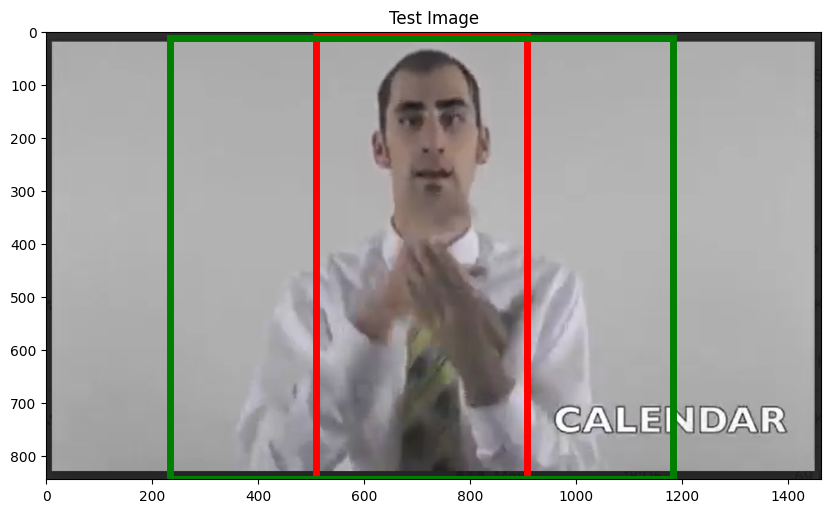

In [93]:
# Showing the test image with the true and the predicted bounding box => green = true bounding box, red = predicted bounding box
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
fig, ax = plt.subplots(figsize=(10,10))

min_point_pred = (coords_3[0], coords_3[2])
w_pred = coords_3[1] - coords_3[0]
h_pred = coords_3[3] - coords_3[2]

min_point_true = (coords_true[0], coords_true[2])
w_true = coords_true[1] - coords_true[0]
h_true = coords_true[3] - coords_true[2]

rect_pred = patches.Rectangle(min_point_pred, w_pred, h_pred, linewidth=5, edgecolor='r', facecolor='none')
rect_true = patches.Rectangle(min_point_true, w_true, h_true, linewidth=5, edgecolor='g', facecolor='none')
ax.add_patch(rect_pred)
ax.add_patch(rect_true)
ax.imshow(img)
plt.title('Test Image')

In this case the Intersection over Union would be 0.5 as the red bounding box fills nearly half of the green bounding box

## 3. Combination of Detection and Recognition

### 3.0 Prequesites for combining the Models

In [44]:
# Video titles to select from for cutting and cropping
kuerzel = ['wqDOKXEx24M',
'IKfQ-Cra9Bc',
'kwCfdkhc37c',
'R-2MXm-JM0Q',
'uE3IDWh0xnA']

In [46]:
# Directory with the original videos which are cut and cropped
richtige_videos = os.listdir('/content/drive/MyDrive/DeepSL/MSASL100/Test/test')

In [70]:
# Function used to remove the cut/cropped videos before testing another video
# shutil.rmtree("/content/cropped_videos")

In [71]:
# Functions to create the directory which is used to store the cut and cropped videos
os.mkdir("/content/cropped_videos")
os.mkdir("/content/cropped_videos/test")

In [72]:
# Loops to copy the cut and cropped videos saved on drive previously in this notebook (cut/crop step) to a local folder for using them for evaluating the recognition taks
for item in richtige_videos:
  for video_name in kuerzel[4]:
    if item.startswith(kuerzel[4]):
      if item.endswith("cropped.mp4"):
        shutil.copy('/content/drive/MyDrive/DeepSL/MSASL100/Test/test/' +item, "/content/cropped_videos/test")

In [50]:
# Function to tranform the cut and cropped videos to frames as the recognition model can handle them better
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [51]:
# Another function to tranform the cut and cropped videos to frames as the recognition model can handle them better
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [52]:
# Function to preprocess 3d data, needed as the signs cannot be classified when they are treated as 2d images
def preprocess_3d_data(data):
    # Randomly crop the video.
    crop_size = (10, 224, 224, 3)
    data_shape = tf.shape(data)
    data = tf.image.random_crop(data, size=(data_shape[0], crop_size[0], crop_size[1], crop_size[2], crop_size[3]))

    # Randomly flip the video horizontally.
    data = tf.map_fn(lambda x: tf.image.random_flip_left_right(x), data)

    return data

In [90]:
# Class for the augmentation layer later used in the EfficientNet
class DataAugmentationLayer(Layer):
    def __init__(self, **kwargs):
        super(DataAugmentationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return preprocess_3d_data(inputs)

In [91]:
# Function to create the preprocessign layer for the later created EfficientNet
def create_preprocessing_layer(input_shape: Tuple = (10, 224, 224, 3), rescaling = True):
    video_input = tf.keras.Input(shape=input_shape)
    x = ZeroPadding3D(padding=((0, 0),(4,4),(4,4)))(video_input)
    x = DataAugmentationLayer()(x)
    if rescaling:
      x = tf.keras.layers.Rescaling(scale=255)(x)
    return video_input, x

In [55]:
# Class to transform the cut and cropped video in order to make them predictable for the recognition model
class FrameGenerator:

    def __init__(self, path, n_frames, training=False):

        """Returns a set of frames with their associated label.
        Args:

          path: Video file paths.

          n_frames: Number of frames.

          training: Boolean to determine if training dataset is being created.

        """

        self.path = path

        self.n_frames = n_frames

        self.training = training

        self.class_names = sorted(

            set(p.name for p in self.path.iterdir() if p.is_dir())

        )

        self.class_ids_for_name = dict(

            (name, idx) for idx, name in enumerate(self.class_names)

        )

    def get_files_and_class_names(self):

        video_paths = list(self.path.glob("*/*.mp4"))

        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):

        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:

            random.shuffle(pairs)

        for path, name in pairs:

            video_frames = frames_from_video_file(path, self.n_frames)

            label = self.class_ids_for_name[name]  # Encode labels

            yield video_frames, label, path

In [56]:
# Function with the labels of the ASL100 data set
def create_class_names():
    return ['now',
'computer',
'doctor',
'walk',
'nothing',
'forget',
'no',
'chicken',
'please',
'write',
'learn',
'paper',
'help',
'man',
'name',
'play',
'cousin',
'spring',
'where',
'hearing',
'brown',
'black',
'teacher',
'how',
'red',
'hello',
'right',
'big',
'want',
'fish',
'sit',
'tired',
'yellow',
'live',
'hungry',
'table',
'white',
'who',
'like',
'grandmother',
'work',
'need',
'lost',
'you',
'same',
'milk',
'sign',
'girl',
'brother',
'hurt',
'day',
'father',
'sick',
'orange',
'boy',
'nurse',
'bad',
'fine',
'english',
'bathroom',
'yes',
'dance',
'know',
'school',
'what',
'mother',
'green',
'when',
'nice',
'blue',
'student',
'sorry',
'night',
'book',
'here',
'understand',
'friend',
'draw',
'different',
'water',
'again',
'france',
'drink',
'sad',
'thank you',
'finish',
'beautiful',
'sister',
'read',
'happy',
'bird',
'pencil',
'grandfather',
'woman',
'good',
'family',
'eat',
'deaf',
'bored',
'pink']

In [57]:
# Function to use the recognition model to predict labels for the cut and cropped videos
def recognize_video_folder(video_file_path, model):

    chosen_fg = FrameGenerator(pathlib.Path(video_file_path), 10, training=False)


    labels: list = []

    try:

      for chosen_frames, true_label, path in chosen_fg():
          # model prediction
          chosen_frames_expanded = np.expand_dims(chosen_frames, axis=0)

          predicted_label = np.argmax(model.predict(chosen_frames_expanded), axis=-1)
          print(predicted_label)

          # Get the true label's class name
          true_class_name = chosen_fg.class_names[true_label]

          # get the predicted labels class name
          CLASS_NAMES = create_class_names()

          predicted_class_name = CLASS_NAMES[predicted_label[0]]

          labels.append({path: predicted_class_name})

          print(f"True label: {true_label} ({true_class_name})")

          print(f"Predicted label: {predicted_label[0]} ({predicted_class_name})")

    except:
      pass

    print(labels)
    return labels

### 3.1 Combining the Models

In [58]:
# Function to create the EfficientNet used for the recognition task
def create_efficient_net_model(base_model_trainable: bool = True, rescaling: bool = True):

  net = tf.keras.applications.EfficientNetB0(include_top = False)
  net.trainable = base_model_trainable

  input_shape = (10, 224, 224, 3)
  video_input, x = create_preprocessing_layer(input_shape, rescaling = rescaling)

  x = tf.keras.layers.TimeDistributed(net)(x)
  x = tf.keras.layers.Dense(100)(x)
  x = tf.keras.layers.GlobalAveragePooling3D()(x)

  return tf.keras.Model(inputs=video_input, outputs=x)

In [89]:
# Creating the recognition model
model = create_efficient_net_model()

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [73]:
# Loading the weights of the recognition model from drive
model.load_weights("/content/drive/MyDrive/training_checkpoints_efficientNet/cp-0021.ckpt")

### 3.2 Predicted of the combined Model

In [96]:
# Saving the true labels from the cut and cropped video
true_labels = labels_from_json_1

In [74]:
# Using the recognition model to predict on the cut and cropped videos
predicted_labels = recognize_video_folder('/content/cropped_videos', model)

1/1 [==============================] - 0s 74ms/step
[40]
True label: 0 (test)
Predicted label: 40 (work)
1/1 [==============================] - 0s 49ms/step
[0]
True label: 0 (test)
Predicted label: 0 (now)
1/1 [==============================] - 0s 51ms/step
[10]
True label: 0 (test)
Predicted label: 10 (learn)
1/1 [==============================] - 0s 50ms/step
[28]
True label: 0 (test)
Predicted label: 28 (want)
1/1 [==============================] - 0s 61ms/step
[53]
True label: 0 (test)
Predicted label: 53 (orange)
1/1 [==============================] - 0s 53ms/step
[40]
True label: 0 (test)
Predicted label: 40 (work)
1/1 [==============================] - 0s 53ms/step
[25]
True label: 0 (test)
Predicted label: 25 (hello)
1/1 [==============================] - 0s 50ms/step
[33]
True label: 0 (test)
Predicted label: 33 (live)
1/1 [==============================] - 0s 52ms/step
[44]
True label: 0 (test)
Predicted label: 44 (same)
1/1 [==============================] - 0s 51ms/step
[4

In [81]:
# Storing the predictions in a list to compare them with the true labels
predicted_labels_list = []
for i in predicted_labels:
  predicted_labels_list.extend(list(i.values()))

### 3.3 Evaluation of the combined Model

Nicht alle True labels sind Teil der 100 ASL Klassen auf denen trainiert wurde. Aus den True Labels befinden sich XYZ Labels in den 100 Klassen. Das führt dazu, dass...

In [95]:
# Printing the true labels and the predictions to show that they don´t have the same number as the start/end points are not perfectly predicted
print('True Labels: ', len(true_labels), ' ', true_labels)
print('Predictions: ', len(predicted_labels_list), ' ', predicted_labels_list)

True Labels:  12   ['weather', 'sun', 'rain', 'show', 'cold', 'cool', 'hot', 'warm', 'autumn', 'winter', 'spring', 'summer']
Predictions:  19   ['work', 'now', 'learn', 'want', 'orange', 'work', 'hello', 'live', 'same', 'work', 'work', 'work', 'teacher', 'right', 'woman', 'teacher', 'paper', 'same', 'want']


In [88]:
# Counting how many sign were predicted right and saving the label
z = 0
right_prediction = []

for i in true_labels:
  if i in predicted_labels_list:
    z +=1
    right_prediction.append(i)

print('Number of prediction = true label: ', z)
print('Correct predicted sign: ', right_prediction)

Number of prediction = true label:  1
Correct predicted sign:  ['woman']
